##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Neural Network (CNN)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.


### Import TensorFlow

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

from PIL import Image
import os
import numpy as np
import pandas as pd

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [ ]:

IMG_SIZE = 128

def cargarImagenes(imagPath):
  classes_ori = [] 
  images_ori = []
  esDA_ori = []
  usarDA = True
  all_dirs = os.listdir( imagPath )
  for each_dir in all_dirs:

      auxiPath = imagPath + '/' + each_dir 
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:

            esImagDA = (each_imagFN[:2] == 'da')
            
            if usarDA or (not esImagDA): 
                
                # abre la imagen
                imag = Image.open(auxiPath + "/" + each_imagFN)
                
                # ajusta el tamaño             
                tipoImage = 'RGB'
                imag = imag.convert(tipoImage)
                imag = imag.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)          
                
                # transforma a un vector de nros
                arImag = np.array(imag)
                
                # agrega a los vectores
                pepe = -1
                if each_dir == 'Bishop':
                  pepe = 0
                if each_dir == 'King':
                  pepe = 1
                if each_dir == 'Knight':
                  pepe = 2
                if each_dir == 'Pawn':
                  pepe = 3
                if each_dir == 'Queen':
                  pepe = 4
                if each_dir == 'Rook':
                  pepe = 5

                classes_ori.append( [pepe] )
                images_ori.append( arImag )
                esDA_ori.append( esImagDA )

  return classes_ori, images_ori, esDA_ori, tipoImage

def prepare_imageList(imagList):    
  auxiAr = np.array(imagList).astype('float32') / 255.
  auxiAr = auxiAr.reshape((len(auxiAr), IMG_SIZE*IMG_SIZE*3))  
  return np.array(auxiAr)

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demoIA/imagenesAjedrez' #@param {type:"string"}
path_entrenamiento = '/train'  #@param {type:"string"}
path_prueba = '/test'  #@param {type:"string"}

imagPath_train = path + path_entrenamiento
imagPath_test = path + path_prueba

classes_train, images_train, esDAimag_train, tipoImage_train = cargarImagenes(imagPath_train)

classes_test, images_test, esDAimag_test, tipoImage_test = cargarImagenes(imagPath_test)

# (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images = np.array(images_train).reshape(-1, IMG_SIZE, IMG_SIZE, 3) # prepare_imageList(images_train)
train_labels = classes_train
test_images = np.array(images_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3) # prepare_imageList(images_test)
test_labels = classes_test

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

Mounted at /content/gdrive


### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


In [ ]:
class_names = ['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']

# plt.figure(figsize=(10,10))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(train_images[i])
#     # The CIFAR labels happen to be arrays, 
#     # which is why you need the extra index
#     plt.xlabel(class_names[train_labels[i][0]])
# plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (5, 5), activation='relu'))

# model = models.Sequential()
# model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
# model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# model.add(layers.Conv2D(32, (3, 3), activation='relu'))

# # model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# # model.add(layers.MaxPooling2D((2, 2)))
# # model.add(layers.Dropout(0.2))

# model.add(layers.Conv2D(32, (5, 5), activation='relu'))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.Conv2D(94, (3, 3), activation='relu'))

# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.BatchNormalization(momentum=0.3))
# model.add(layers.Dropout(0.2))


Let's display the architecture of your model so far:

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 128)     

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(6))

Here's the complete architecture of your model:

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 128)     

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

In [ ]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(type(train_images))

test_labels = np.array(test_labels)
train_labels = np.array(train_labels)

history = model.fit(train_images, train_labels, epochs=60, 
                    validation_data=(test_images, test_labels))

<class 'numpy.ndarray'>
Epoch 1/60
8/8 [==============================] - 2s 86ms/step - loss: 1.8667 - accuracy: 0.1701 - val_loss: 1.7869 - val_accuracy: 0.1562
Epoch 2/60
8/8 [==============================] - 0s 28ms/step - loss: 1.7886 - accuracy: 0.1950 - val_loss: 1.7859 - val_accuracy: 0.1771
Epoch 3/60
8/8 [==============================] - 0s 34ms/step - loss: 1.7779 - accuracy: 0.2490 - val_loss: 1.7805 - val_accuracy: 0.1979
Epoch 4/60
8/8 [==============================] - 0s 29ms/step - loss: 1.7487 - accuracy: 0.2739 - val_loss: 1.7998 - val_accuracy: 0.2292
Epoch 5/60
8/8 [==============================] - 0s 33ms/step - loss: 1.7250 - accuracy: 0.2656 - val_loss: 1.7799 - val_accuracy: 0.2083
Epoch 6/60
8/8 [==============================] - 0s 29ms/step - loss: 1.6902 - accuracy: 0.3154 - val_loss: 1.7527 - val_accuracy: 0.2188
Epoch 7/60
8/8 [==============================] - 0s 34ms/step - loss: 1.6242 - accuracy: 0.3278 - val_loss: 1.6058 - val_accuracy: 0.3646
Epo

### Evaluate the model

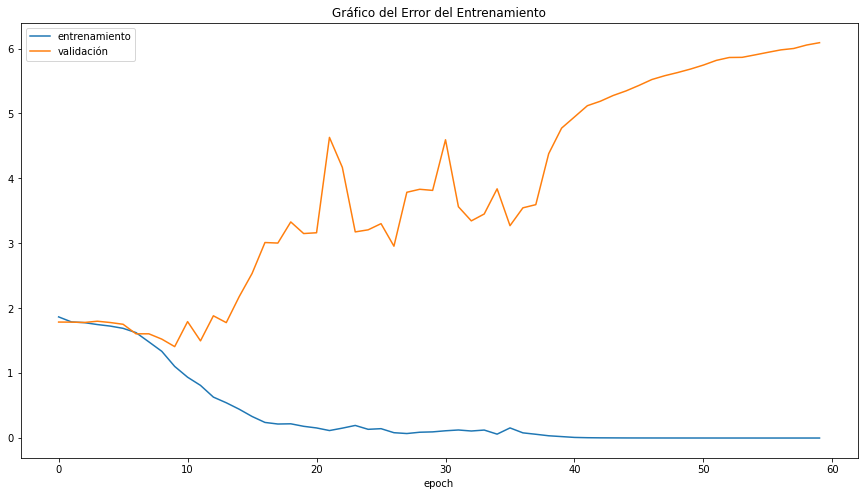

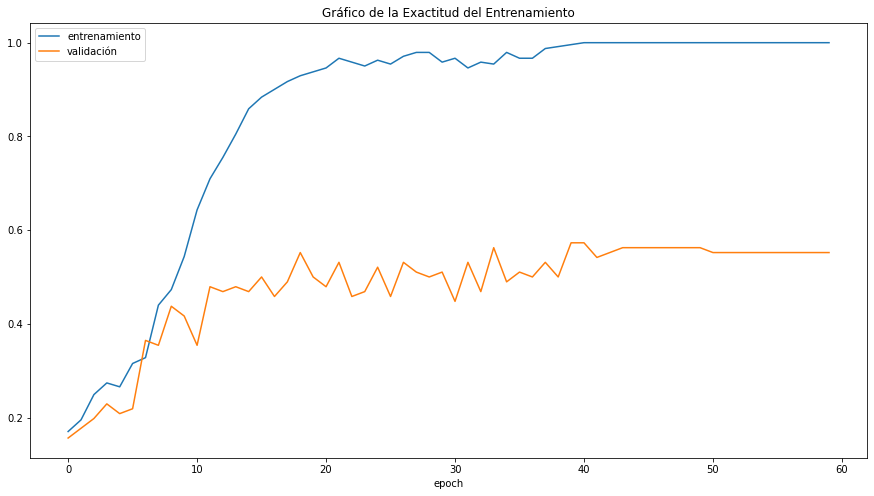

In [ ]:
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
# plt.legend(loc='lower right')

plt.figure(figsize=(15,8)) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

plt.figure(figsize=(15,8)) 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Gráfico de la Exactitud del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()


In [ ]:

resEval = model.evaluate(test_images,  test_labels,)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")

def probarModelo(x, y, clases_map):

    # procesa las imágenes de prueba con el modelo 
    predClass = model.predict(x)

    # muestra los resultados con las imágenes 
    umbralClas = 0.5
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # asigna el nombre de la clase real
        clReal = clases_map[ y[i][0] ] 
        
        idclPred = int( np.argmax(predClass[i], axis=0) )
        idclPredRnd = idclPred

        # asigna el nombre de la clase predecida
        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA!"
        else:      
            clPred = clases_map[ idclPredRnd ]

        # agrega a vevtores auxiliares
        classReal.append( clReal )
        classPreds.append( clPred )

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión: ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm, 
        index=['r:{:}'.format(x) for x in clases_map], 
        columns=['p:{:}'.format(x) for x in clases_map]
      )
    print(cmtx)
    print("\n")

print("*** Resultados con datos de Entrenamiento: ")
probarModelo(train_images, train_labels, ['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook'])

print("*** Resultados con datos de Prueba: ")
probarModelo(test_images, test_labels, ['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook'])

3/3 [==============================] - 0s 12ms/step - loss: 6.0909 - accuracy: 0.5521

>Evaluación del Modelo: 
    - Error:  6.09092378616333
    - Exactitud:  55.20833134651184


*** Resultados con datos de Entrenamiento: 

 Reporte de Clasificación: 
              precision    recall  f1-score   support

      Bishop       1.00      1.00      1.00        47
        King       1.00      1.00      1.00        35
      Knight       1.00      1.00      1.00        48
        Pawn       1.00      1.00      1.00        39
       Queen       1.00      1.00      1.00        31
        Rook       1.00      1.00      1.00        41

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241


Matriz de Confusión: 
          p:Bishop  p:King  p:Knight  p:Pawn  p:Queen  p:Rook
r:Bishop        47       0         0       0        0       0
r:King           0      35         0       0        0   

Your simple CNN has achieved a test accuracy of over 70%. Not bad for a few lines of code! For another CNN style, check out the [TensorFlow 2 quickstart for experts](https://www.tensorflow.org/tutorials/quickstart/advanced) example that uses the Keras subclassing API and `tf.GradientTape`.